# Final project: Time-series data and application to stock markets {-}

This project aims at familiarizing you with time-series data analysis and its application to stock markets. Datasets you will be working on are Nasdaq and Vietnam stock datasets.

### Submission {-}
The structure of submission folder should be organized as follows:

- ./\<StudentID>-project-notebook.ipynb: Jupyter notebook containing source code.
- ./\<StudentID>-project-report.pdf: project report.

The submission folder is named DL4AI-\<StudentID>-project (e.g., DL4AI-2012345-project) and then compressed with the same name.
    
### Evaluation {-}
Project evaluation will be conducted on how you accomplish the assignment requirements. You can refer to the project instruction slide deck for details.

### Deadline {-}
Please visit Canvas for details.

# NASDAQ PRICE PREDICTION


In [ ]:
# Your code goes here

In [ ]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#I picked a list of 10 top tech companies from the Nasdaq market
COMPANY_NAMES = raw = """AAPL.csv
ADBE.csv
ADSK.csv
AMD.csv
AMZN.csv
INTC.csv
MSFT.csv
NVDA.csv
QCOM.csv
V.csv"""


In [ ]:
company_list = COMPANY_NAMES.split("\n")

In [ ]:
# Function to check if a given string is a date
# that happened before another date
def isBefore(this,other):
  this_dates = this.split("-")
  other_dates = other.split("-")
  this_day = this_dates[0]
  this_month = this_dates[1]
  this_year = this_dates[2]
  other_day = other_dates[0]
  other_month = other_dates[1]
  other_year = other_dates[2]
  if (this_year != other_year):
    return (this_year < other_year )
  elif (this_month != other_month):
    return (this_month < other_month)
  else:
    return this_day < other_day

In [ ]:
X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []

window_size=30 # Time window for data feature (size of 'number of days').
days_ahead = 3
predict_sequence = True

In [ ]:
#Splitting the train,val,test datasets
for name in company_list[:5]:
  url = f"https://raw.githubusercontent.com/phnam05/nasdaq/main/tech_companies/{name}"
  df = pd.read_csv(url)

# Only get the open price (index 2 in the data frame)
  for i in range(0, len(df) - window_size - days_ahead):
      data_feature = []
      data_label = []

      # Get a window_size time frame for data feature
      for j in range(window_size):
          data_feature.append(df.iloc[i + j, 2])

      # Next value is the label (price of the next day) to be predicted
      if predict_sequence:
        data_label.append([df.iloc[i + window_size+ day, 2]for day in range(days_ahead)])
      else:
        data_label.append(df.iloc[i+window_size+days_ahead,2])
      current_date = df["Date"][i+window_size+days_ahead]
      if isBefore(current_date,"12-01-2022"):
        # Append new data sample (feature and label) to X_data and y_data
        X_train.append(np.array(data_feature).reshape(window_size, 1))
        y_train.append(np.array(data_label))
      elif (isBefore(current_date, "12-06-2022")):
        X_val.append(np.array(data_feature).reshape(window_size, 1))
        y_val.append(np.array(data_label))
      else:
        X_test.append(np.array(data_feature).reshape(window_size, 1))
        y_test.append(np.array(data_label))

In [ ]:
# Convert from lists to Numpy arrays for reshaping purpose
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Reshape the numpy array to fit the neural network input shape requirement
X_train = X_train.reshape(X_train.shape[0], window_size, 1)
X_val = X_val.reshape(X_val.shape[0], window_size, 1)
X_test = X_test.reshape(X_test.shape[0], window_size, 1)

# Print shape of the training, validation and test set
print("Shape of training set: ", X_train.shape)
print("Shape of validation set: ", X_val.shape)
print("Shape of test set: ", X_test.shape)

Shape of training set:  (45095, 30, 1)
Shape of validation set:  (520, 30, 1)
Shape of test set:  (635, 30, 1)


In [ ]:
# MinMax normalize the training data: x=(x-min(x)/(max(x)-min(x))
X_train_norm = X_train.copy()
y_train_norm = y_train.copy()
for i in range(0, len(X_train)):
    min_feature = np.min(X_train[i])
    max_feature = np.max(X_train[i])
    if (max_feature == min_feature):
      continue
    X_train_norm[i] = (X_train[i] - min_feature) / (max_feature - min_feature)
    y_train_norm[i] = (y_train[i] - min_feature) / (max_feature - min_feature)

# MinMax normalize the validation data: x=(x-min(x)/(max(x)-min(x))
X_val_norm = X_val.copy()
y_val_norm = y_val.copy()
for i in range(0, len(X_val)):
    min_feature = np.min(X_val[i])
    max_feature = np.max(X_val[i])
    if (max_feature == min_feature):
      continue
    X_val_norm[i] = (X_val[i] - min_feature) / (max_feature - min_feature)
    y_val_norm[i] = (y_val[i] - min_feature) / (max_feature - min_feature)

In [ ]:
### Create and train the model

# Import libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,LSTM

epochs = 20
batch_size = 512
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(1e-1,epochs*len(X_train)/batch_size)
optimizer = tf.keras.optimizers.AdamW(lr_schedule, weight_decay=0.1)

# Build the model architecture
if predict_sequence:
  model = tf.keras.Sequential([
      tf.keras.layers.GRU(days_ahead),
      tf.keras.layers.Dense(4096),
      tf.keras.layers.Dense(100,activation='relu'),
      tf.keras.layers.Dense(10,activation='relu'),
      tf.keras.layers.Dense(days_ahead),
  ])
else:
  model = tf.keras.Sequential([
    tf.keras.layers.GRU(1),
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1),
])

# Compile and train the model with Mean Squared Error loss function
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=epochs, batch_size=batch_size)

Epoch 1/20
89/89 [==============================] - 10s 10ms/step - loss: 0.0680 - mse: 0.0680 - val_loss: 0.0278 - val_mse: 0.0278
Epoch 2/20
89/89 [==============================] - 0s 5ms/step - loss: 0.0303 - mse: 0.0303 - val_loss: 0.0275 - val_mse: 0.0275
Epoch 3/20
89/89 [==============================] - 0s 5ms/step - loss: 0.0313 - mse: 0.0313 - val_loss: 0.0270 - val_mse: 0.0270
Epoch 4/20
89/89 [==============================] - 0s 5ms/step - loss: 0.0300 - mse: 0.0300 - val_loss: 0.0260 - val_mse: 0.0260
Epoch 5/20
89/89 [==============================] - 0s 5ms/step - loss: 0.0300 - mse: 0.0300 - val_loss: 0.0295 - val_mse: 0.0295
Epoch 6/20
89/89 [==============================] - 1s 7ms/step - loss: 0.0296 - mse: 0.0296 - val_loss: 0.0265 - val_mse: 0.0265
Epoch 7/20
89/89 [==============================] - 1s 7ms/step - loss: 0.0298 - mse: 0.0298 - val_loss: 0.0268 - val_mse: 0.0268
Epoch 8/20
89/89 [==============================] - 1s 8ms/step - loss: 0.0300 - mse: 0.

In [ ]:
# MinMax normalize the test data: norm_x = (x-min(x) / (max(x) - min(x))
X_test_norm = X_test.copy()
y_test_norm = y_test.copy()
min_feature = np.min(X_test)
max_feature = np.max(X_test)
for i in range(0, len(X_test)):
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    if (max_feature == min_feature):
      continue
    X_test_norm[i] = (X_test[i] - min_feature) / (max_feature - min_feature)
    y_test_norm[i] = (y_test[i] - min_feature) / (max_feature - min_feature)

In [ ]:
### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_norm = model.predict(X_test_norm)
if not predict_sequence:
  print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

20/20 [==============================] - 1s 2ms/step


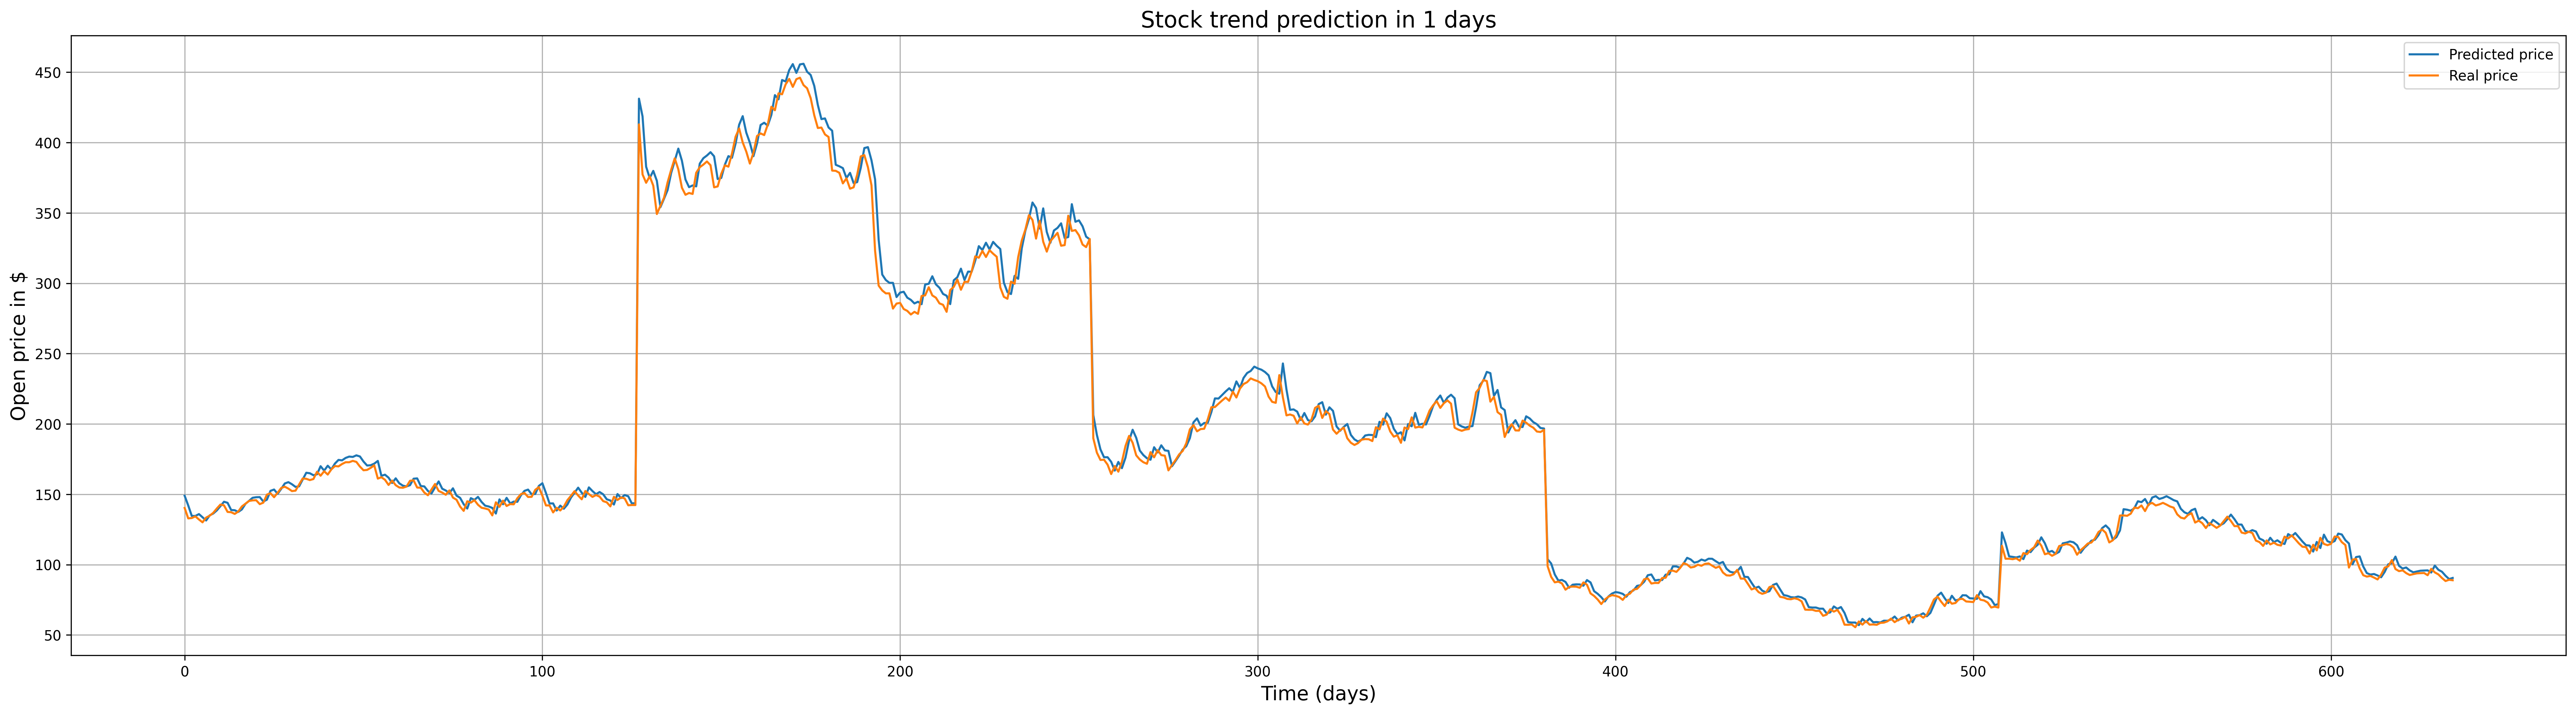

In [ ]:
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_denorm = y_pred_norm
for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    y_pred_denorm[i] = y_pred_norm[i] * (max_feature - min_feature) + min_feature

# y_test_plot = flatten(y_test)
# y_pred_denorm_plot = flatten(y_pred_denorm)

# Visualize preditec stock price versus real stock price
plt.figure(figsize=(32, 8), dpi=300)
if predict_sequence:
  plt.plot(y_pred_denorm.reshape(len(y_pred_denorm) * days_ahead), label='Predicted price')
  plt.plot(y_test.reshape(len(y_pred_denorm) * days_ahead), label='Real price')
else:
  plt.plot(y_pred_denorm[:125],label='Predicted price')
  plt.plot(y_test[:125], label='Real price')
plt.title(f'Stock trend prediction in {days_ahead} days', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

## Check the accuracy of the model by testing it on an 11th company of choice

In [ ]:
url = "https://raw.githubusercontent.com/phnam05/nasdaq/main/OKE.csv"

In [ ]:
X_predict = []
y_predict = []

In [ ]:
df = pd.read_csv(url)

# Only get the open price (index 2 in the data frame)
for i in range(0, len(df) - window_size - days_ahead):
      data_feature = []
      data_label = []
      current_date = df["Date"][i+window_size+days_ahead]
      if not isBefore(current_date,"12-06-2022"):
        # Get a window_size time frame for data feature
        for j in range(window_size):
            data_feature.append(df.iloc[i + j, 2])

        # Next value is the label (price of the next day) to be predicted
        if predict_sequence:
          data_label.append([df.iloc[i + window_size+ day, 2]for day in range(days_ahead)])
        else:
          data_label.append(df.iloc[i+window_size+days_ahead,2])

          # Append new data sample (feature and label) to X_data and y_data
        X_predict.append(np.array(data_feature).reshape(window_size, 1))
        y_predict.append(np.array(data_label))

In [ ]:
X_test = X_predict.copy()
y_test = y_predict.copy()

In [ ]:
X_test = np.array(X_test)
y_test = np.array(y_test)
X_test = X_test.reshape(X_test.shape[0], window_size, 1)

In [ ]:
print("Shape of test set: ", X_test.shape)

Shape of test set:  (127, 30, 1)


In [ ]:
X_test_norm = X_test.copy()
y_test_norm = y_test.copy()
min_feature = np.min(X_test)
max_feature = np.max(X_test)
for i in range(0, len(X_test)):
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    if (max_feature == min_feature):
      continue
    X_test_norm[i] = (X_test[i] - min_feature) / (max_feature - min_feature)
    y_test_norm[i] = (y_test[i] - min_feature) / (max_feature - min_feature)

In [ ]:
min_feature = np.min(X_test)
max_feature = np.max(X_test)
for i in range(0, len(X_test)):
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    if (max_feature == min_feature):
      continue
    X_test_norm[i] = (X_test[i] - min_feature) / (max_feature - min_feature)
    y_test_norm[i] = (y_test[i] - min_feature) / (max_feature - min_feature)

In [ ]:
### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_norm = model.predict(X_test_norm)
if not predict_sequence:
  print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

4/4 [==============================] - 0s 3ms/step


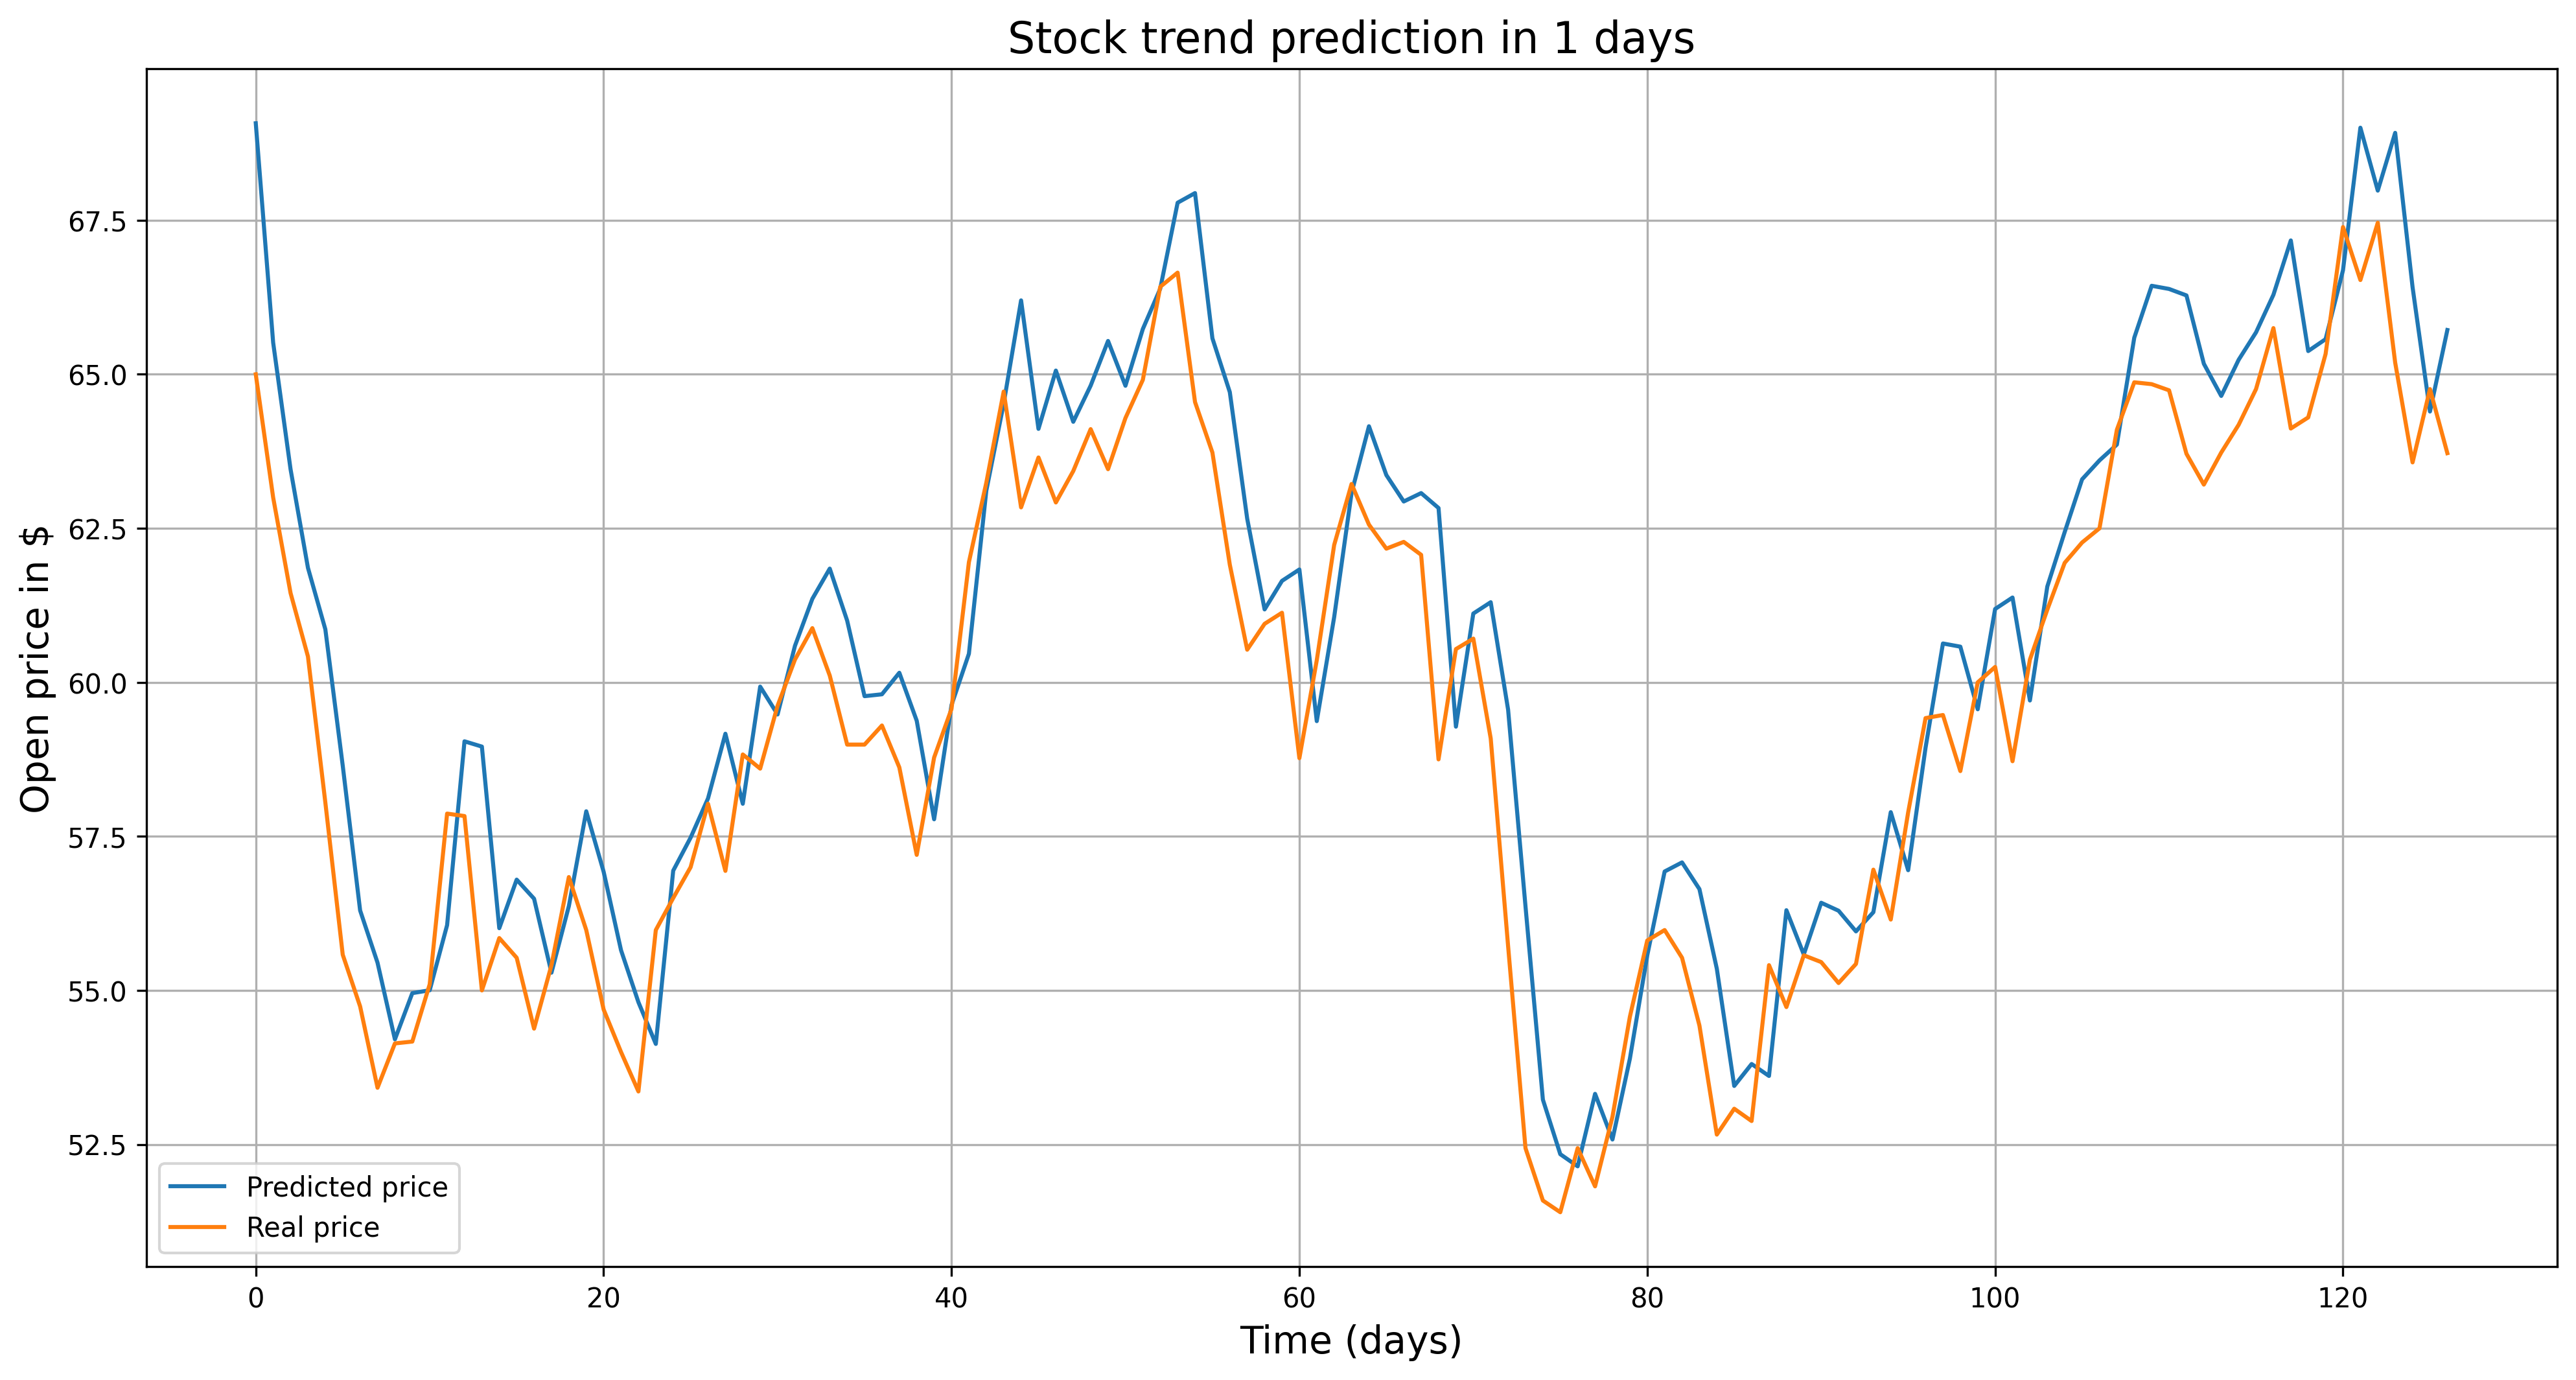

In [ ]:
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_denorm = y_pred_norm
for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    y_pred_denorm[i] = y_pred_norm[i] * (max_feature - min_feature) + min_feature

# y_test_plot = flatten(y_test)
# y_pred_denorm_plot = flatten(y_pred_denorm)

# Visualize preditec stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
if predict_sequence:
  plt.plot(y_pred_denorm.reshape(len(y_pred_denorm) * days_ahead), label='Predicted price')
  plt.plot(y_test.reshape(len(y_pred_denorm) * days_ahead), label='Real price')
else:
  plt.plot(y_pred_denorm,label='Predicted price')
  plt.plot(y_test, label='Real price')
plt.title(f'Stock trend prediction in {days_ahead} days', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()